In [1]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
class TwoLayerMLP(nn.Module):

    def __init__(self, d):
        super(TwoLayerMLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 100),
            nn.Dropout(d),
            nn.Tanh(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        logits = self.layer(x)
        return logits

In [4]:
def train_epoch(dataloader, model, criterion, optimizer, regularizer):
    
    size = len(dataloader.dataset)
    
    for batchnum, (X, y) in enumerate(dataloader):
        yhat = model(X)
        loss = criterion(yhat, y)
        loss += regularizer(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0:
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def validate(dataloader, model, criterion, regularizer):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    test_loss += regularizer(model)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [16]:
def reg_WD(model):
    res = 0
    lmb = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res += (p**2).sum()
    return lmb*res

def train(model, reg):
    lr = 1e-3
    batch_size = 128
    epochs = 20

    train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=1)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    
    accuracy = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model.train()
        train_epoch(train_loader, model, criterion, optimizer, reg)
        model.eval()
        accuracy.append(validate(test_loader, model, criterion, reg))


    print("Done!")
    return accuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model = TwoLayerMLP(0).to(device)
baseWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.349782  [    0/60000]
loss: 0.768066  [12800/60000]
loss: 0.537044  [25600/60000]
loss: 0.557657  [38400/60000]
loss: 0.483473  [51200/60000]
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.452008 

Epoch 2
-------------------------------
loss: 0.504960  [    0/60000]
loss: 0.392525  [12800/60000]
loss: 0.436622  [25600/60000]
loss: 0.413022  [38400/60000]
loss: 0.406276  [51200/60000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.408402 

Epoch 3
-------------------------------
loss: 0.343023  [    0/60000]
loss: 0.451343  [12800/60000]
loss: 0.242409  [25600/60000]
loss: 0.270171  [38400/60000]
loss: 0.313496  [51200/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.378854 

Epoch 4
-------------------------------
loss: 0.336205  [    0/60000]
loss: 0.348686  [12800/60000]
loss: 0.374044  [25600/60000]
loss: 0.311065  [38400/60000]
loss: 0.259978  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.390310 

Epoch 5
------------------------

In [13]:
def reg_WD(model):
    res = 0
    lmb = 1e-4
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res += (p**2).sum()
    return lmb*res

model = TwoLayerMLP(0).to(device)
largeWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.334199  [    0/60000]
loss: 0.659320  [12800/60000]
loss: 0.503487  [25600/60000]
loss: 0.533034  [38400/60000]
loss: 0.403245  [51200/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.468966 

Epoch 2
-------------------------------
loss: 0.314982  [    0/60000]
loss: 0.375545  [12800/60000]
loss: 0.322349  [25600/60000]
loss: 0.419225  [38400/60000]
loss: 0.445326  [51200/60000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.411096 

Epoch 3
-------------------------------
loss: 0.544896  [    0/60000]
loss: 0.502925  [12800/60000]
loss: 0.450712  [25600/60000]
loss: 0.346514  [38400/60000]
loss: 0.270157  [51200/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.390023 

Epoch 4
-------------------------------
loss: 0.373292  [    0/60000]
loss: 0.266813  [12800/60000]
loss: 0.381803  [25600/60000]
loss: 0.243125  [38400/60000]
loss: 0.424886  [51200/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.378112 

Epoch 5
------------------------

In [14]:
def reg_WD(model):
    res = 0
    lmb = 1e-6
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res += (p**2).sum()
    return lmb*res

model = TwoLayerMLP(0).to(device)
smallWD = train(model, reg_WD)

Epoch 1
-------------------------------
loss: 2.313428  [    0/60000]
loss: 0.519609  [12800/60000]
loss: 0.574735  [25600/60000]
loss: 0.343534  [38400/60000]
loss: 0.344962  [51200/60000]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.456297 

Epoch 2
-------------------------------
loss: 0.354831  [    0/60000]
loss: 0.404251  [12800/60000]
loss: 0.400613  [25600/60000]
loss: 0.347282  [38400/60000]
loss: 0.408747  [51200/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.411225 

Epoch 3
-------------------------------
loss: 0.322086  [    0/60000]
loss: 0.349705  [12800/60000]
loss: 0.373118  [25600/60000]
loss: 0.648616  [38400/60000]
loss: 0.433475  [51200/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.401828 

Epoch 4
-------------------------------
loss: 0.346267  [    0/60000]
loss: 0.261618  [12800/60000]
loss: 0.458637  [25600/60000]
loss: 0.200741  [38400/60000]
loss: 0.391926  [51200/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.384648 

Epoch 5
------------------------

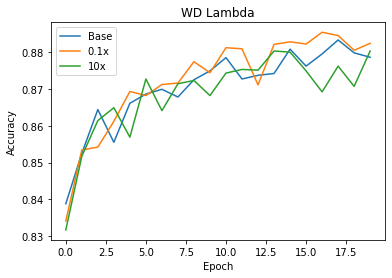

In [15]:
plt.plot(baseWD,label="Base")
plt.plot(smallWD,label="0.1x")
plt.plot(largeWD,label="10x")

plt.title("WD Lambda")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [18]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = TwoLayerMLP(0).to(device)
baseWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.307437  [    0/60000]
loss: 0.582048  [12800/60000]
loss: 0.636012  [25600/60000]
loss: 0.518055  [38400/60000]
loss: 0.449073  [51200/60000]
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.469645 

Epoch 2
-------------------------------
loss: 0.407956  [    0/60000]
loss: 0.397628  [12800/60000]
loss: 0.356108  [25600/60000]
loss: 0.397734  [38400/60000]
loss: 0.342497  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.402874 

Epoch 3
-------------------------------
loss: 0.383056  [    0/60000]
loss: 0.370372  [12800/60000]
loss: 0.299246  [25600/60000]
loss: 0.451698  [38400/60000]
loss: 0.340290  [51200/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.390079 

Epoch 4
-------------------------------
loss: 0.389525  [    0/60000]
loss: 0.383571  [12800/60000]
loss: 0.400323  [25600/60000]
loss: 0.281874  [38400/60000]
loss: 0.360337  [51200/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.374147 

Epoch 5
------------------------

In [19]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-5
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = TwoLayerMLP(0).to(device)
largeEWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.308939  [    0/60000]
loss: 0.594705  [12800/60000]
loss: 0.457711  [25600/60000]
loss: 0.470334  [38400/60000]
loss: 0.456358  [51200/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.463385 

Epoch 2
-------------------------------
loss: 0.413379  [    0/60000]
loss: 0.365933  [12800/60000]
loss: 0.511108  [25600/60000]
loss: 0.634879  [38400/60000]
loss: 0.341166  [51200/60000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.412745 

Epoch 3
-------------------------------
loss: 0.373028  [    0/60000]
loss: 0.391738  [12800/60000]
loss: 0.492352  [25600/60000]
loss: 0.398173  [38400/60000]
loss: 0.318828  [51200/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.383035 

Epoch 4
-------------------------------
loss: 0.423324  [    0/60000]
loss: 0.319513  [12800/60000]
loss: 0.348553  [25600/60000]
loss: 0.282363  [38400/60000]
loss: 0.417860  [51200/60000]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.375220 

Epoch 5
------------------------

In [28]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-7
    lmb_c = 1e-5
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = TwoLayerMLP(0).to(device)
smallEWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.321040  [    0/60000]
loss: 0.633358  [12800/60000]
loss: 0.419245  [25600/60000]
loss: 0.501391  [38400/60000]
loss: 0.462577  [51200/60000]
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.472740 

Epoch 2
-------------------------------
loss: 0.546228  [    0/60000]
loss: 0.471485  [12800/60000]
loss: 0.335149  [25600/60000]
loss: 0.378338  [38400/60000]
loss: 0.541764  [51200/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.415824 

Epoch 3
-------------------------------
loss: 0.360992  [    0/60000]
loss: 0.417566  [12800/60000]
loss: 0.279268  [25600/60000]
loss: 0.345537  [38400/60000]
loss: 0.457079  [51200/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.389275 

Epoch 4
-------------------------------
loss: 0.390897  [    0/60000]
loss: 0.330637  [12800/60000]
loss: 0.420953  [25600/60000]
loss: 0.317051  [38400/60000]
loss: 0.358063  [51200/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.375880 

Epoch 5
------------------------

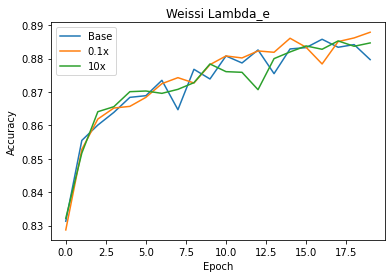

In [29]:
plt.plot(baseWeissi,label="Base")
plt.plot(smallEWeissi,label="0.1x")
plt.plot(largeEWeissi,label="10x")

plt.title("Weissi Lambda_e")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-4
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = TwoLayerMLP(0).to(device)
largeCWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.307294  [    0/60000]
loss: 0.611082  [12800/60000]
loss: 0.493326  [25600/60000]
loss: 0.403830  [38400/60000]
loss: 0.340217  [51200/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.446923 

Epoch 2
-------------------------------
loss: 0.334311  [    0/60000]
loss: 0.313382  [12800/60000]
loss: 0.418150  [25600/60000]
loss: 0.241297  [38400/60000]
loss: 0.326656  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.405878 

Epoch 3
-------------------------------
loss: 0.408350  [    0/60000]
loss: 0.309733  [12800/60000]
loss: 0.279007  [25600/60000]
loss: 0.476248  [38400/60000]
loss: 0.302867  [51200/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.393905 

Epoch 4
-------------------------------
loss: 0.297619  [    0/60000]
loss: 0.223909  [12800/60000]
loss: 0.352845  [25600/60000]
loss: 0.380099  [38400/60000]
loss: 0.363822  [51200/60000]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.371669 

Epoch 5
------------------------

In [27]:
def weissi(model):
    res_e = 1
    res_c = 0
    lmb_e = 1e-6
    lmb_c = 1e-6
    for name, p in model.named_parameters():
        if 'bias' not in name:
            res_e *= torch.linalg.norm(p)**2
            res_c += torch.linalg.norm(p/torch.linalg.norm(p),1)
    return lmb_e * torch.log(res_e) + lmb_c * res_c

model = TwoLayerMLP(0).to(device)
smallCWeissi = train(model, weissi)

Epoch 1
-------------------------------
loss: 2.339534  [    0/60000]
loss: 0.580590  [12800/60000]
loss: 0.529588  [25600/60000]
loss: 0.362084  [38400/60000]
loss: 0.478100  [51200/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.460683 

Epoch 2
-------------------------------
loss: 0.489461  [    0/60000]
loss: 0.467980  [12800/60000]
loss: 0.333310  [25600/60000]
loss: 0.380175  [38400/60000]
loss: 0.280325  [51200/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.409267 

Epoch 3
-------------------------------
loss: 0.466540  [    0/60000]
loss: 0.308473  [12800/60000]
loss: 0.353611  [25600/60000]
loss: 0.388046  [38400/60000]
loss: 0.404540  [51200/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.397719 

Epoch 4
-------------------------------
loss: 0.287941  [    0/60000]
loss: 0.342806  [12800/60000]
loss: 0.407298  [25600/60000]
loss: 0.434316  [38400/60000]
loss: 0.280396  [51200/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.376975 

Epoch 5
------------------------

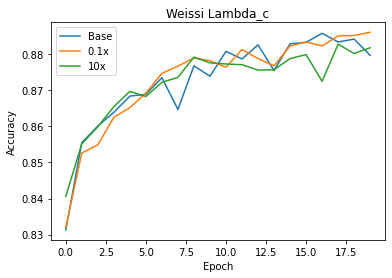

In [31]:
plt.plot(baseWeissi,label="Base")
plt.plot(smallCWeissi,label="0.1x")
plt.plot(largeCWeissi,label="10x")

plt.title("Weissi Lambda_c")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()